### ANOVA results for belief state partitions

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from scripts.anova_analysis.run_anova import load_data
import scipy
import argparse
import copy
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import itertools

### Load data

In [2]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.subject = "BL"
args.trial_event = "FeedbackOnsetLong"
args.conditions = ["BeliefConf", "BeliefPartition"]
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}

In [3]:
pref_res = io_utils.read_anova_good_units(args, "95th", "BeliefPref", return_pos=False)
conf_res = io_utils.read_anova_good_units(args, "95th", "BeliefConf", return_pos=False)

just_pref = pref_res[~pref_res.PseudoUnitID.isin(conf_res.PseudoUnitID)]
just_conf = conf_res[~conf_res.PseudoUnitID.isin(pref_res.PseudoUnitID)]
both = pref_res[pref_res.PseudoUnitID.isin(conf_res.PseudoUnitID)]

### Count units

In [29]:
n_just_pref = just_pref.PseudoUnitID.nunique()
n_just_conf = just_conf.PseudoUnitID.nunique()
n_both = both.PseudoUnitID.nunique()
print(f"Preference selective only: {n_just_pref} units")
print(f"Confidence selective only: {n_just_conf} units")
print(f"Selective for both {n_both} units")
print(f"Total: {n_just_pref + n_just_conf + n_both}")

Preference selective only: 51 units
Confidence selective only: 80 units
Selective for both 27 units
Total: 158


In [30]:
part_res = io_utils.read_anova_good_units(args, "95th", "BeliefPartition", return_pos=False)
print(f"Partition selective in general: {part_res.PseudoUnitID.nunique()} units")


Partition selective in general: 112 units


In [32]:
part_res.groupby("feat").PseudoUnitID.nunique().reset_index(name="num_sig_units").sort_values(by="num_sig_units", ascending=False)

feat  num_sig_units
2     ESCHER             36
8       STAR             19
6     RIPPLE             16
10  TRIANGLE             13
1       CYAN             12
9      SWIRL              9
5   POLKADOT              7
7     SQUARE              7
11    YELLOW              7
0     CIRCLE              6
4    MAGENTA              5
3      GREEN              4

### Save subpops for decoding

In [6]:
sig_path = f"/data/patrick_res/firing_rates/{args.subject}/{args.trial_event}_belief_partition_95th_units.pickle"
part_res.to_pickle(sig_path)


In [7]:
sig_path = f"/data/patrick_res/firing_rates/{args.subject}/{args.trial_event}_belief_pref_95th_units.pickle"
pref_res.to_pickle(sig_path)

In [8]:
sig_path = f"/data/patrick_res/firing_rates/{args.subject}/{args.trial_event}_belief_conf_95th_units.pickle"
conf_res.to_pickle(sig_path)

### Visualization helper:

In [4]:
def plot_psth(unit, args):
    fig, _ = visualization_utils.plot_belief_partition_psth(int(unit.PseudoUnitID), unit.feat, args)
    fig.suptitle(f"{unit.PseudoUnitID}, {unit.feat}, var: {unit.x_BeliefPartition_comb_time_fracvar:.3f}, {unit.structure_level2 if 'stucture_level2' in unit else None}")


### Top 10 Both

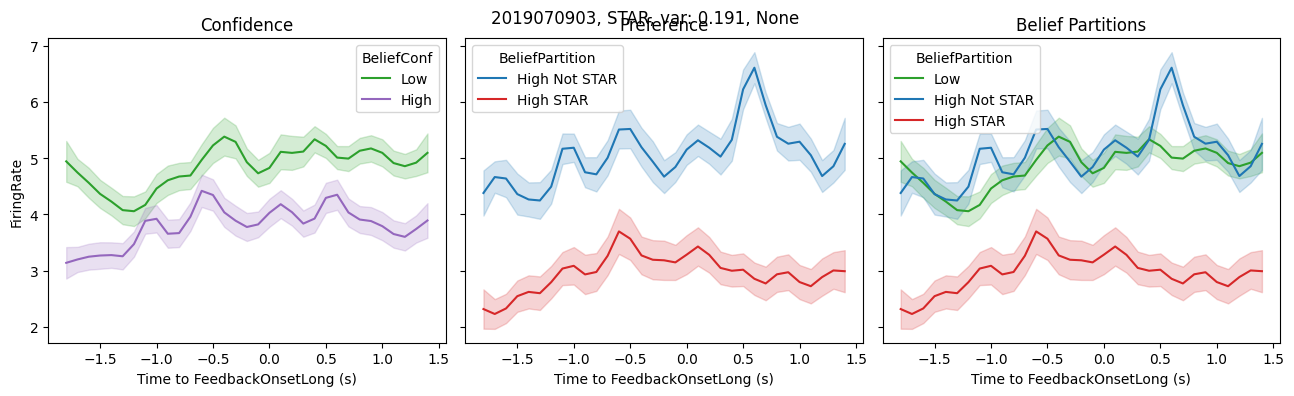

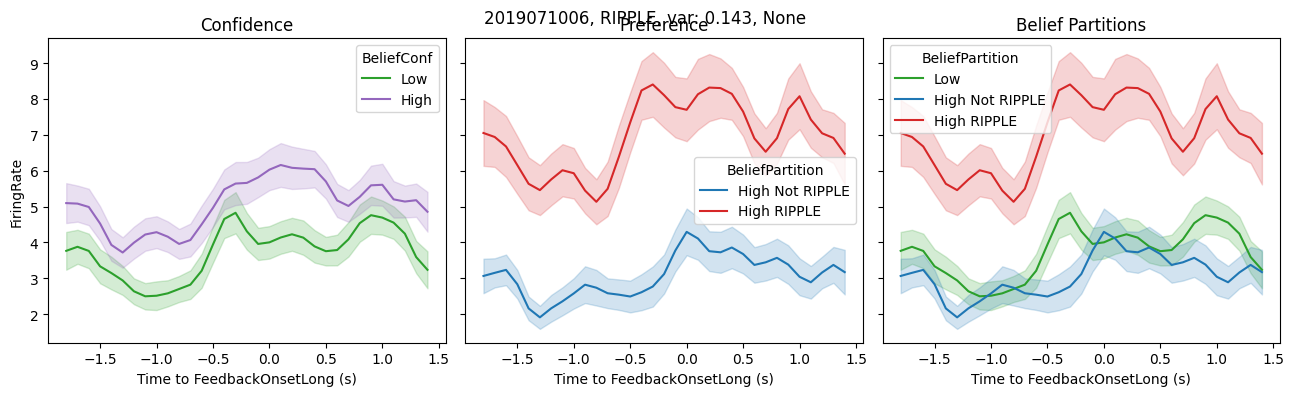

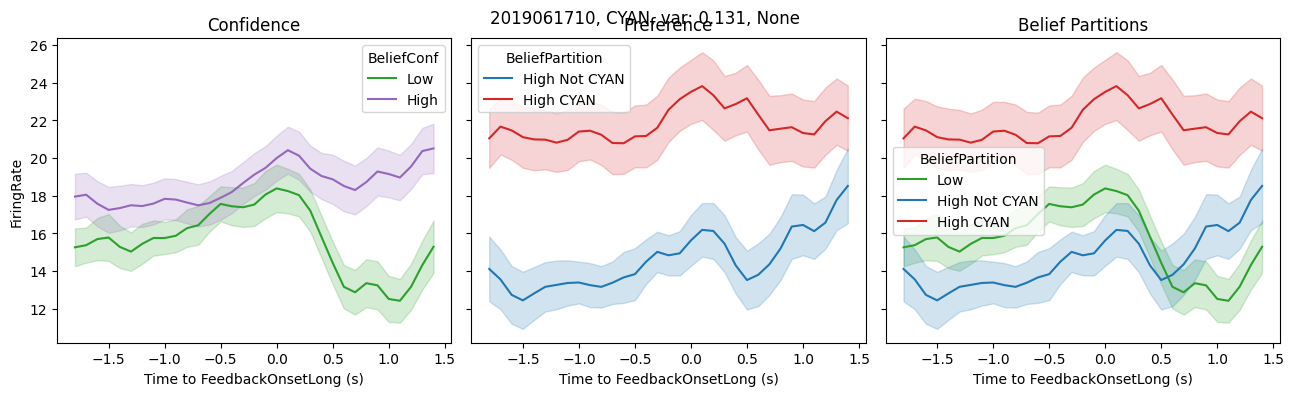

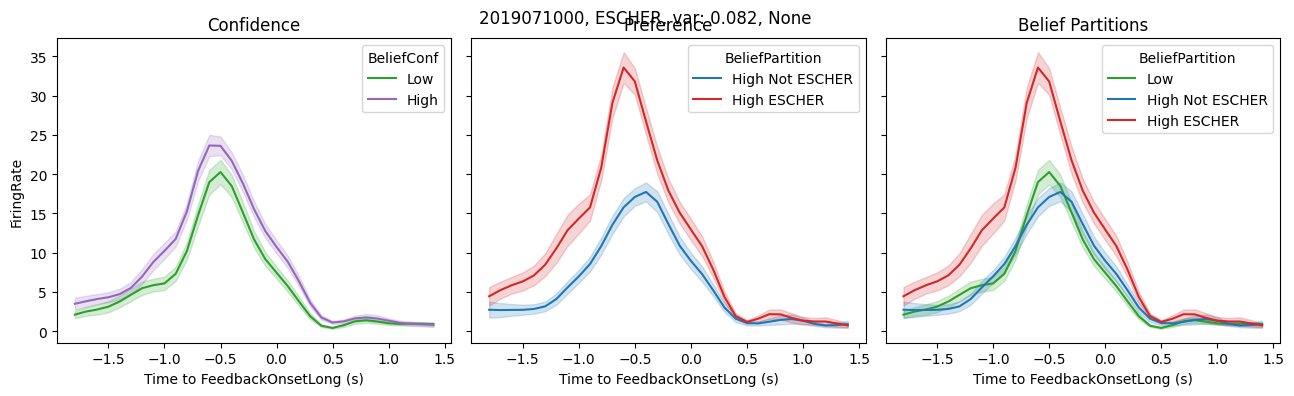

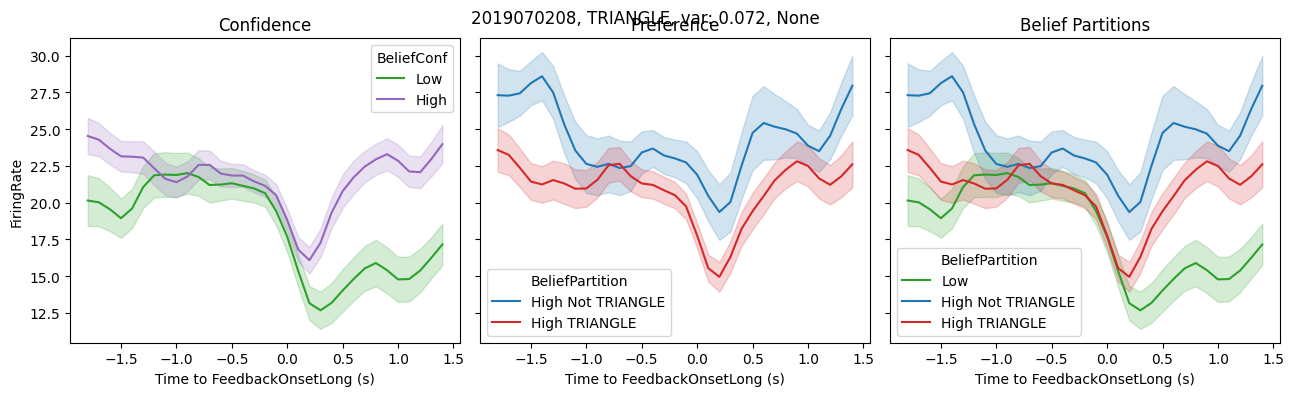

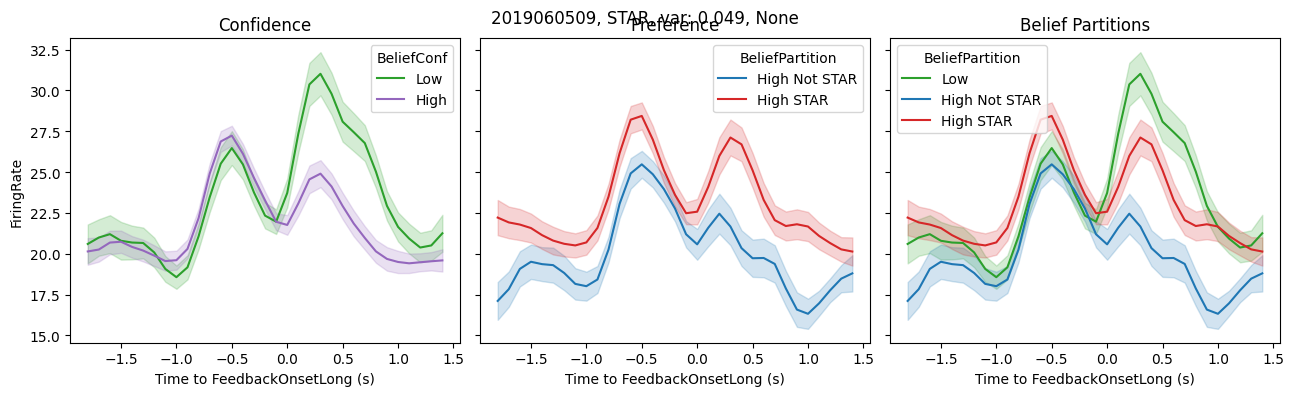

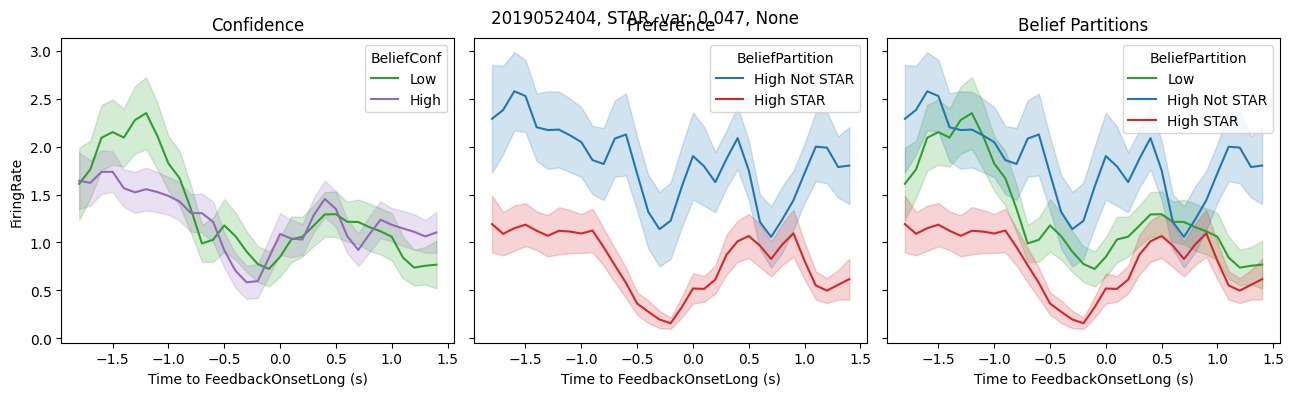

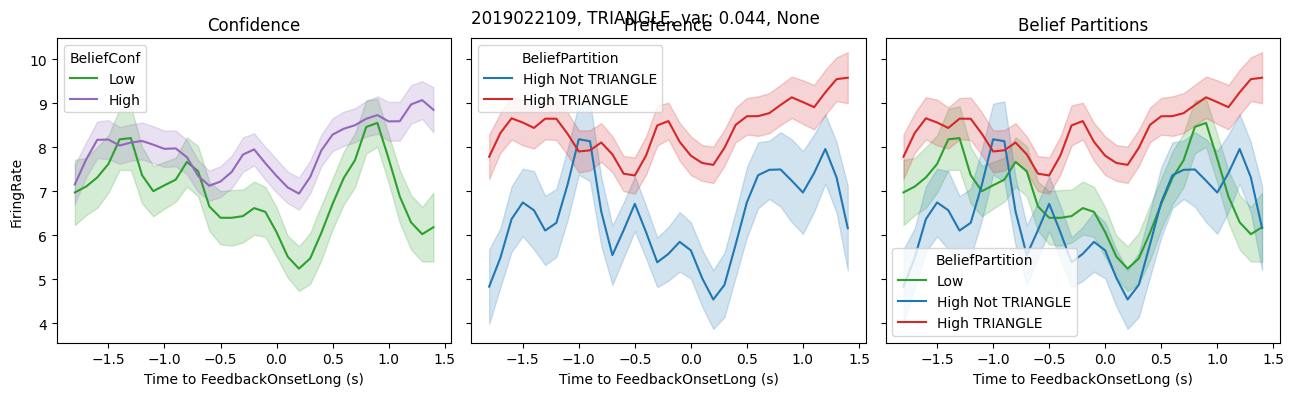

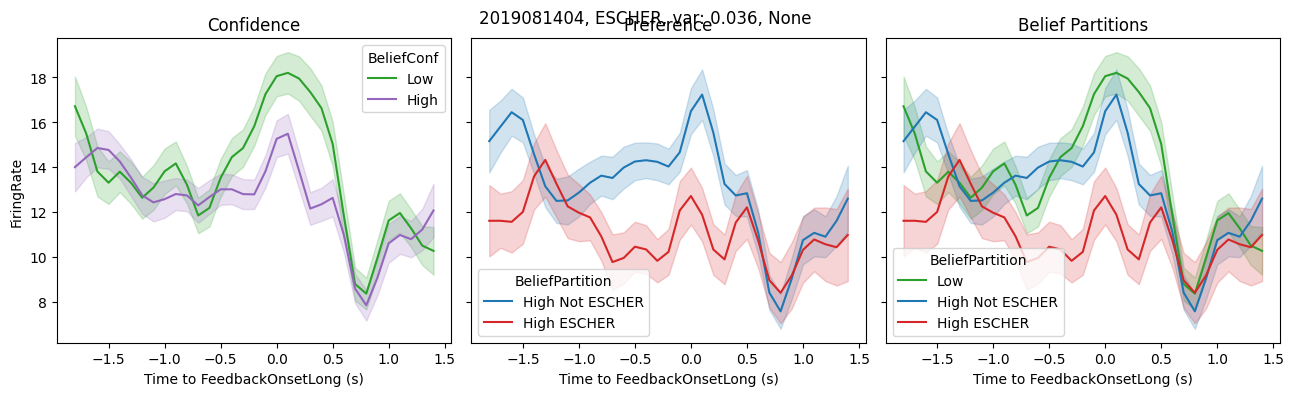

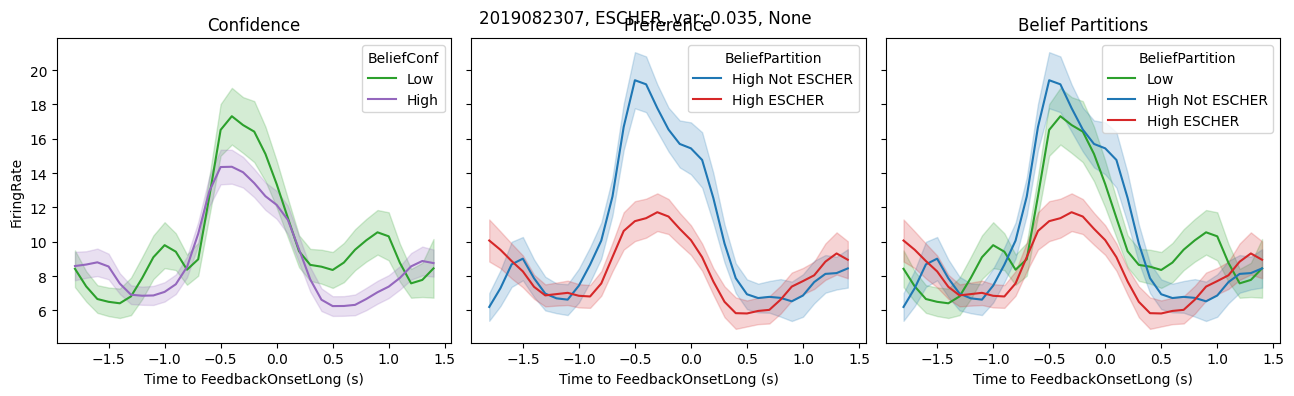

In [5]:
to_vis = both.sort_values("x_BeliefPartition_comb_time_fracvar", ascending=False)[:10]
for i, unit in to_vis.iterrows():
    plot_psth(unit, args)

### Top 10 BeliefConf

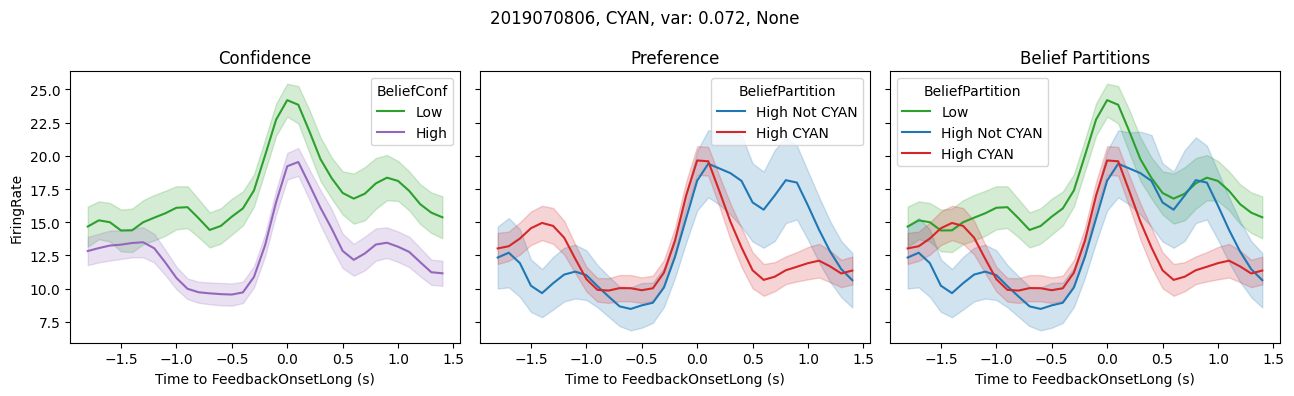

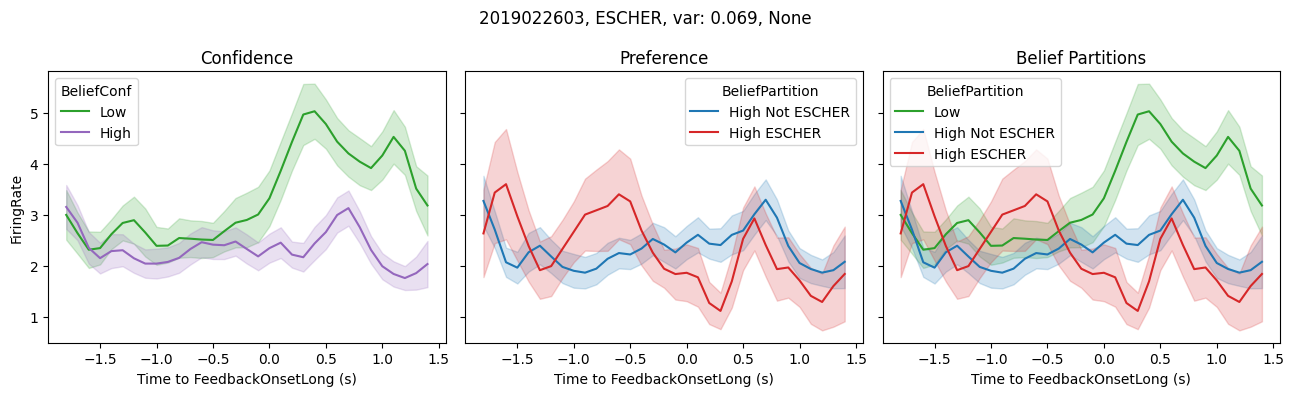

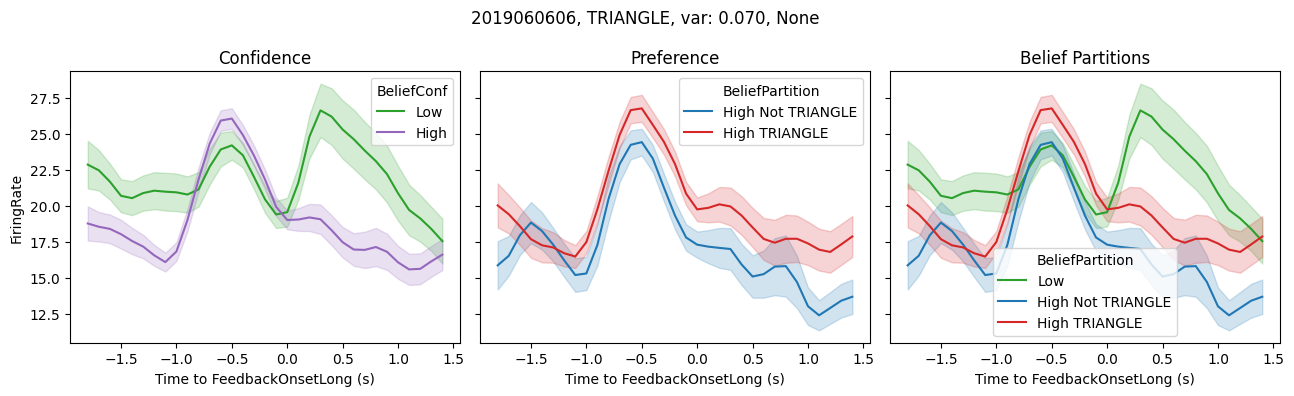

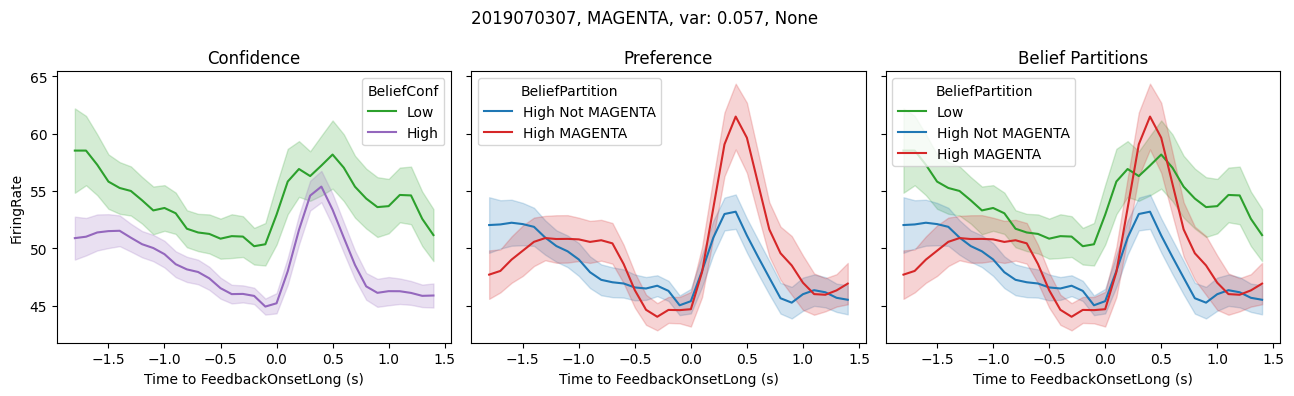

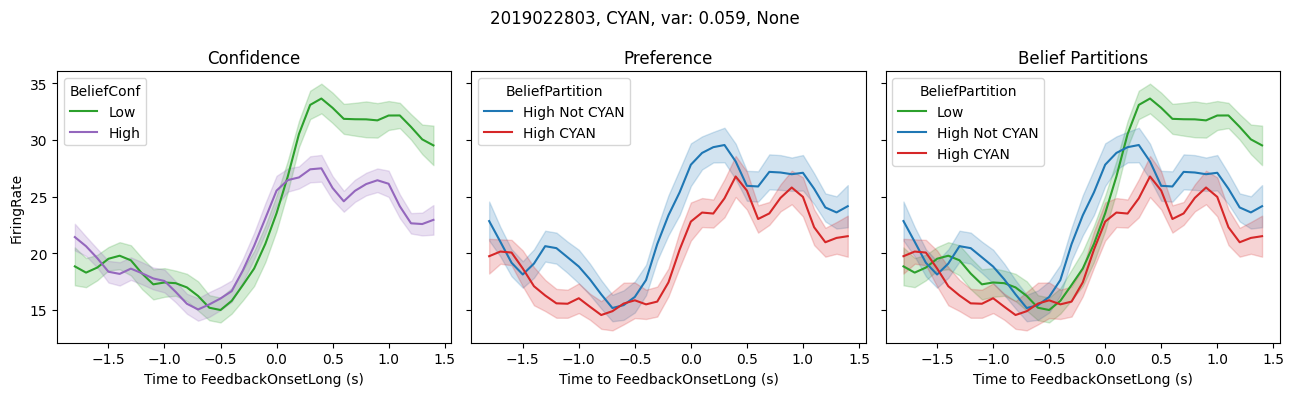

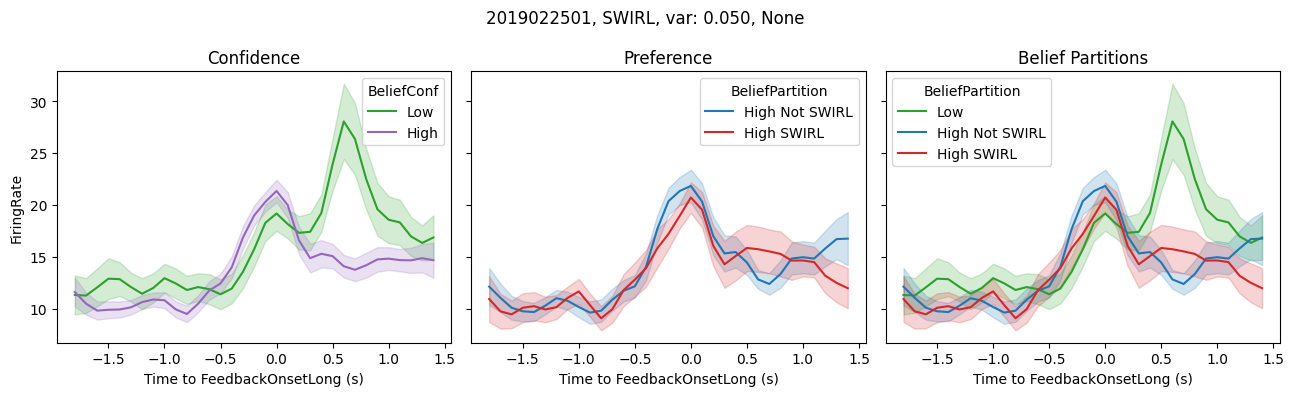

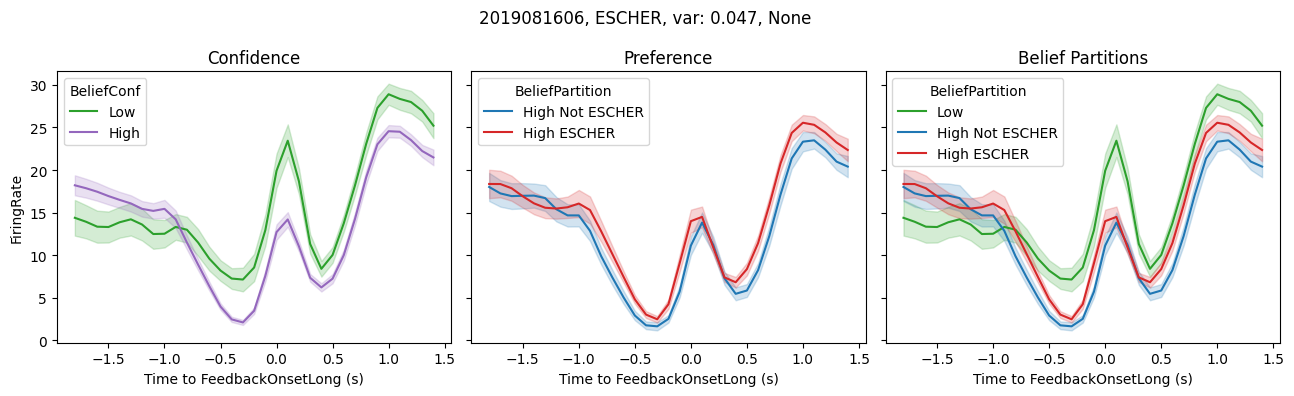

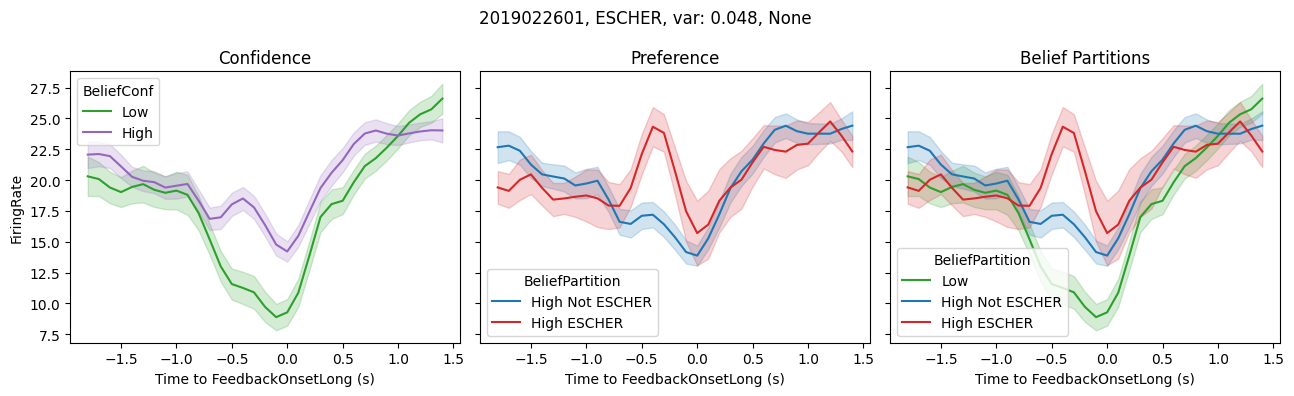

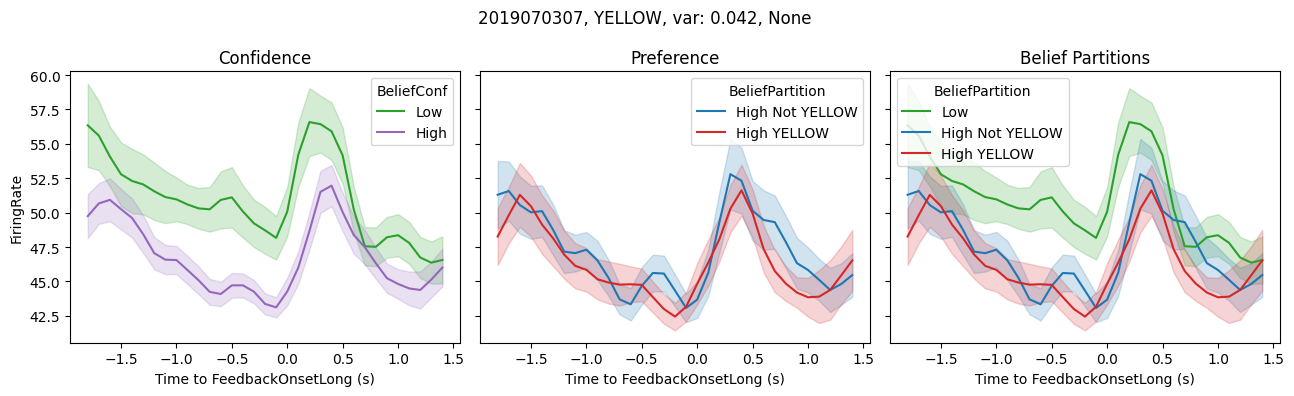

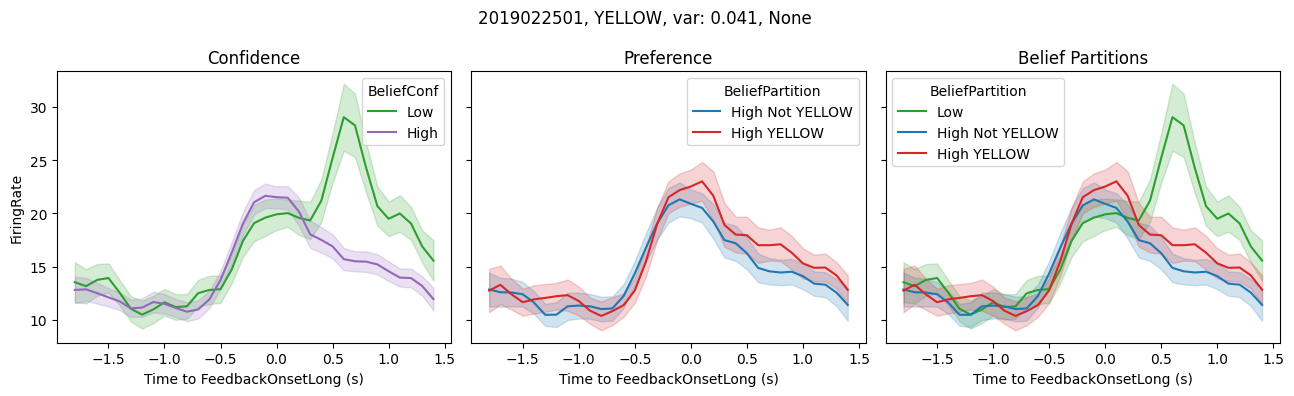

In [35]:
to_vis = just_conf.sort_values("x_BeliefConf_comb_time_fracvar", ascending=False)[:10]
for i, unit in to_vis.iterrows():
    plot_psth(unit, args)

### Top 10 BeliefPref

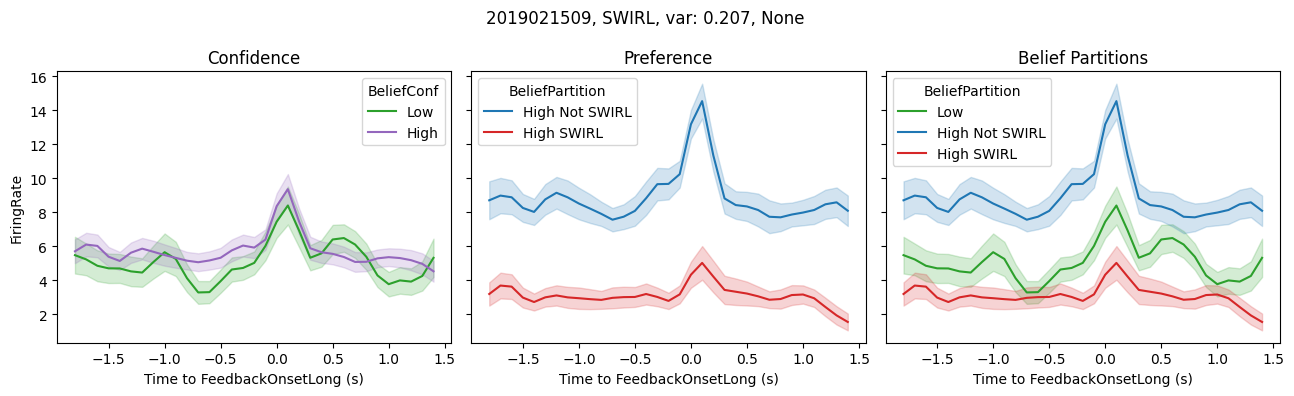

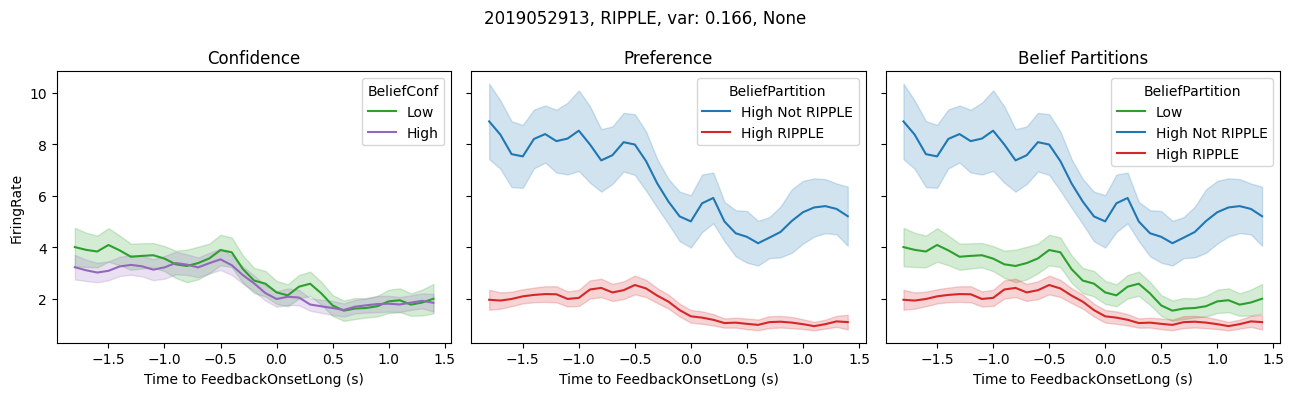

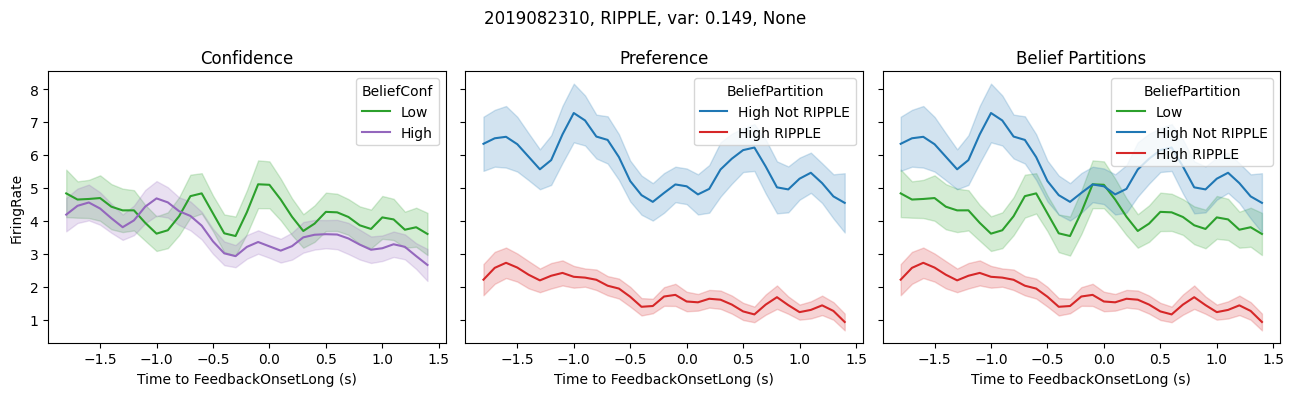

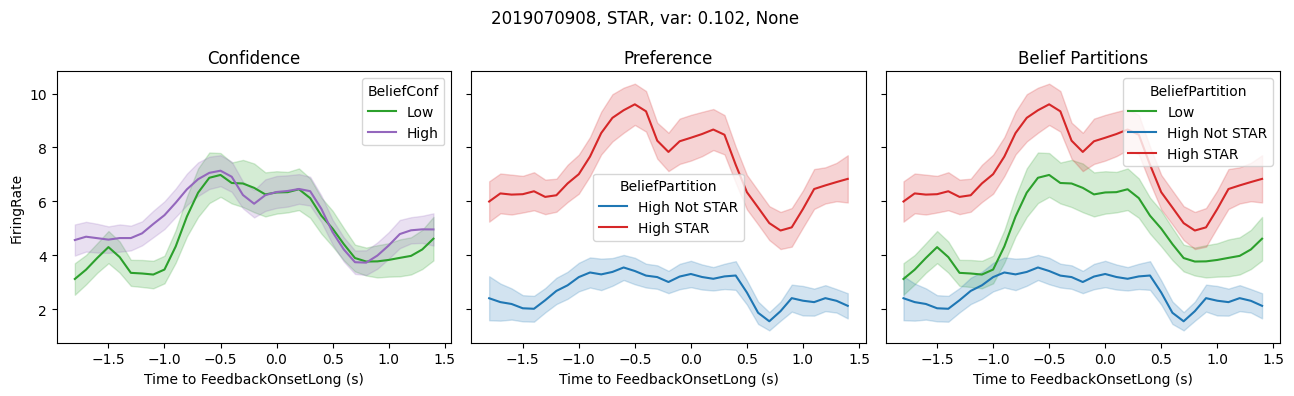

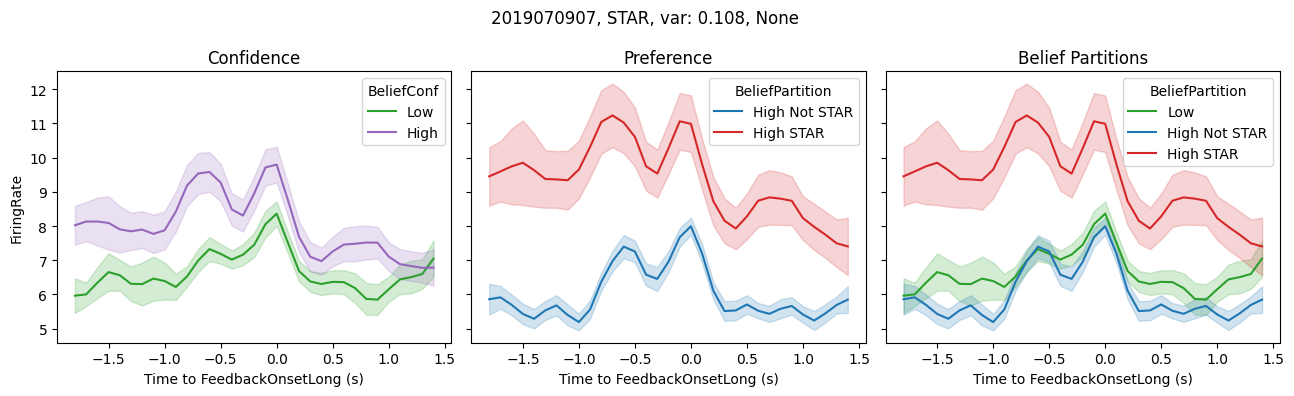

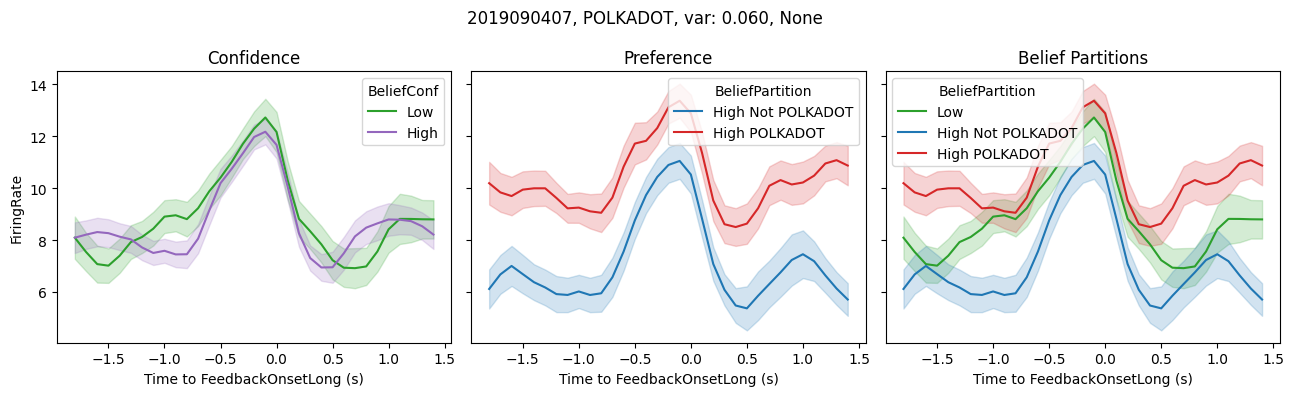

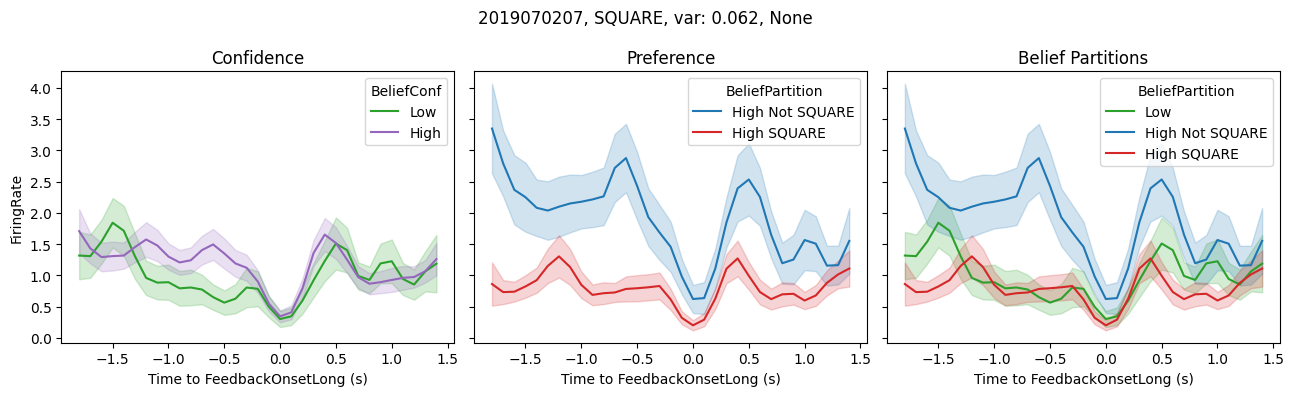

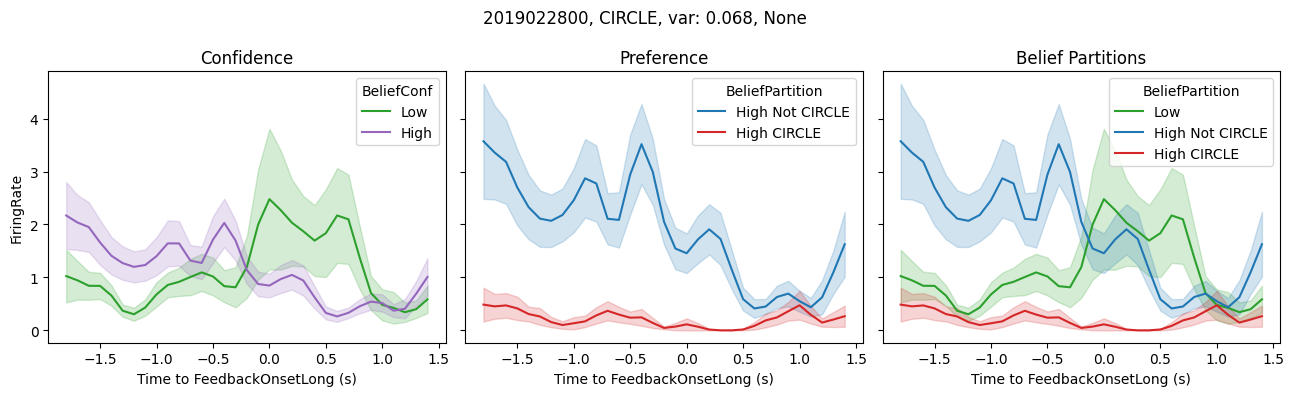

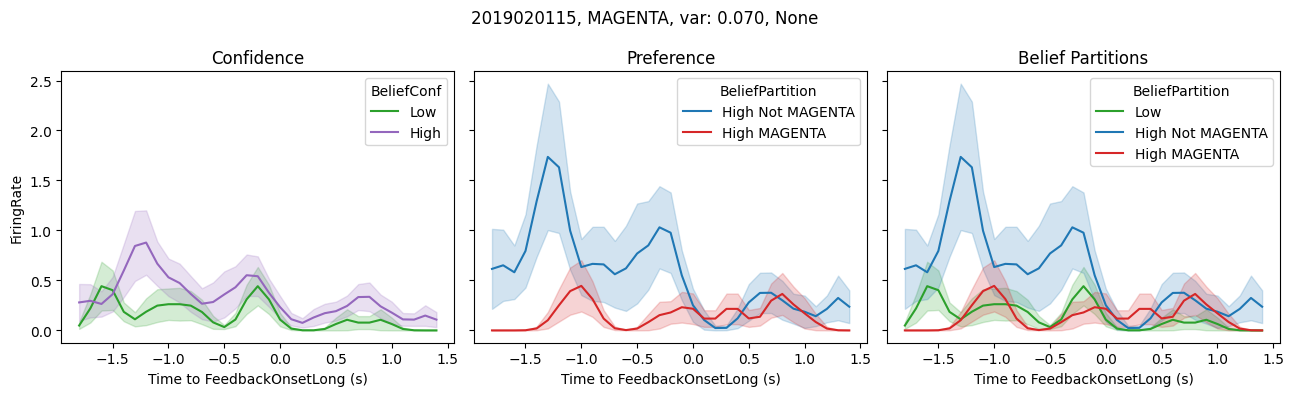

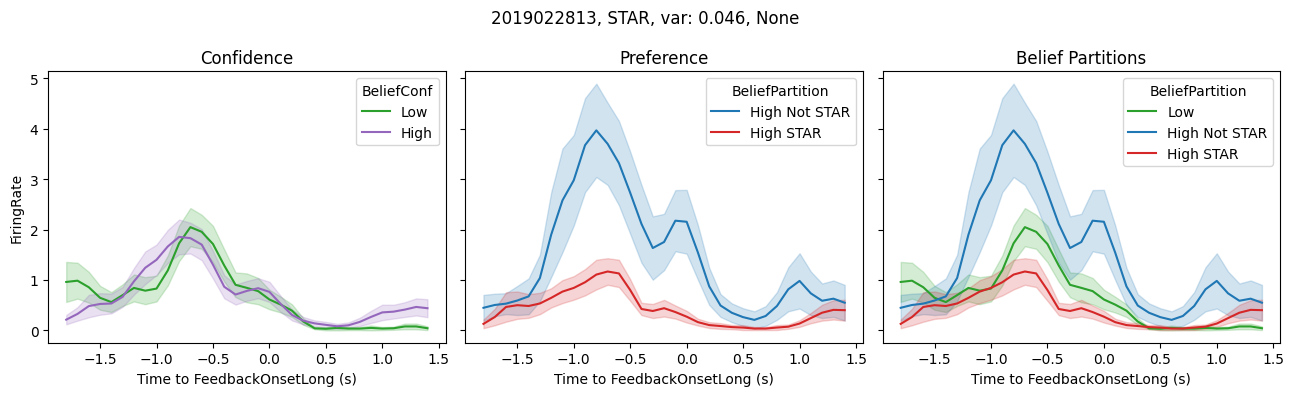

In [36]:
to_vis = just_pref.sort_values("x_BeliefPref_comb_time_fracvar", ascending=False)[:10]
for i, unit in to_vis.iterrows():
    plot_psth(unit, args)

### How much variance is explained by confidence vs. preference in different trial intervals?

In [5]:
unit_pos = pd.read_pickle(UNITS_PATH.format(sub="SA"))
region_totals = unit_pos.groupby("structure_level2").PseudoUnitID.nunique().reset_index(name="num_total")
region_totals = region_totals[region_totals.num_total > 12]
good_structures = region_totals.structure_level2.unique()

In [6]:
def compute_total_frac_vars(x):
    total_pop_var = x.total_var.sum()
    return pd.Series({
        "partition": (x.x_BeliefPartition_comb_time_fracvar * x.total_var).sum() / total_pop_var,
        "conf": (x.x_BeliefConf_comb_time_fracvar * x.total_var).sum() / total_pop_var,
        "pref": (x.x_BeliefPref_comb_time_fracvar * x.total_var).sum() / total_pop_var,
    })

def compute_total_frac_vars_policy(x):
    total_pop_var = x.total_var.sum()
    return pd.Series({
        "policy": (x.x_BeliefPolicy_comb_time_fracvar * x.total_var).sum() / total_pop_var,
    })

def load_fracs(event):
    args = argparse.Namespace(
        **AnovaConfigs()._asdict()
    )
    args.trial_event = event
    args.conditions = ["BeliefConf", "BeliefPartition"]
    args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
    res = io_utils.read_anova_good_units(args, "all", "")
    total_fracs = res.groupby(["feat", "structure_level2"]).apply(compute_total_frac_vars).reset_index()
    total_fracs = pd.melt(total_fracs, id_vars=["feat", "structure_level2"], value_vars=["partition", "conf", "pref"], var_name="partition_type", value_name="frac_variance")
    total_fracs["event"] = event

    args.conditions = ["BeliefPolicy"]
    res = io_utils.read_anova_good_units(args, "all", "")
    policy_fracs = res.groupby(["feat", "structure_level2"]).apply(compute_total_frac_vars_policy).reset_index()
    policy_fracs = pd.melt(policy_fracs, id_vars=["feat", "structure_level2"], value_vars=["policy"], var_name="partition_type", value_name="frac_variance")
    policy_fracs["event"] = event
    return pd.concat((total_fracs, policy_fracs))

In [7]:
all_fracs = pd.concat([load_fracs("StimOnset"), load_fracs("FeedbackOnsetLong")])

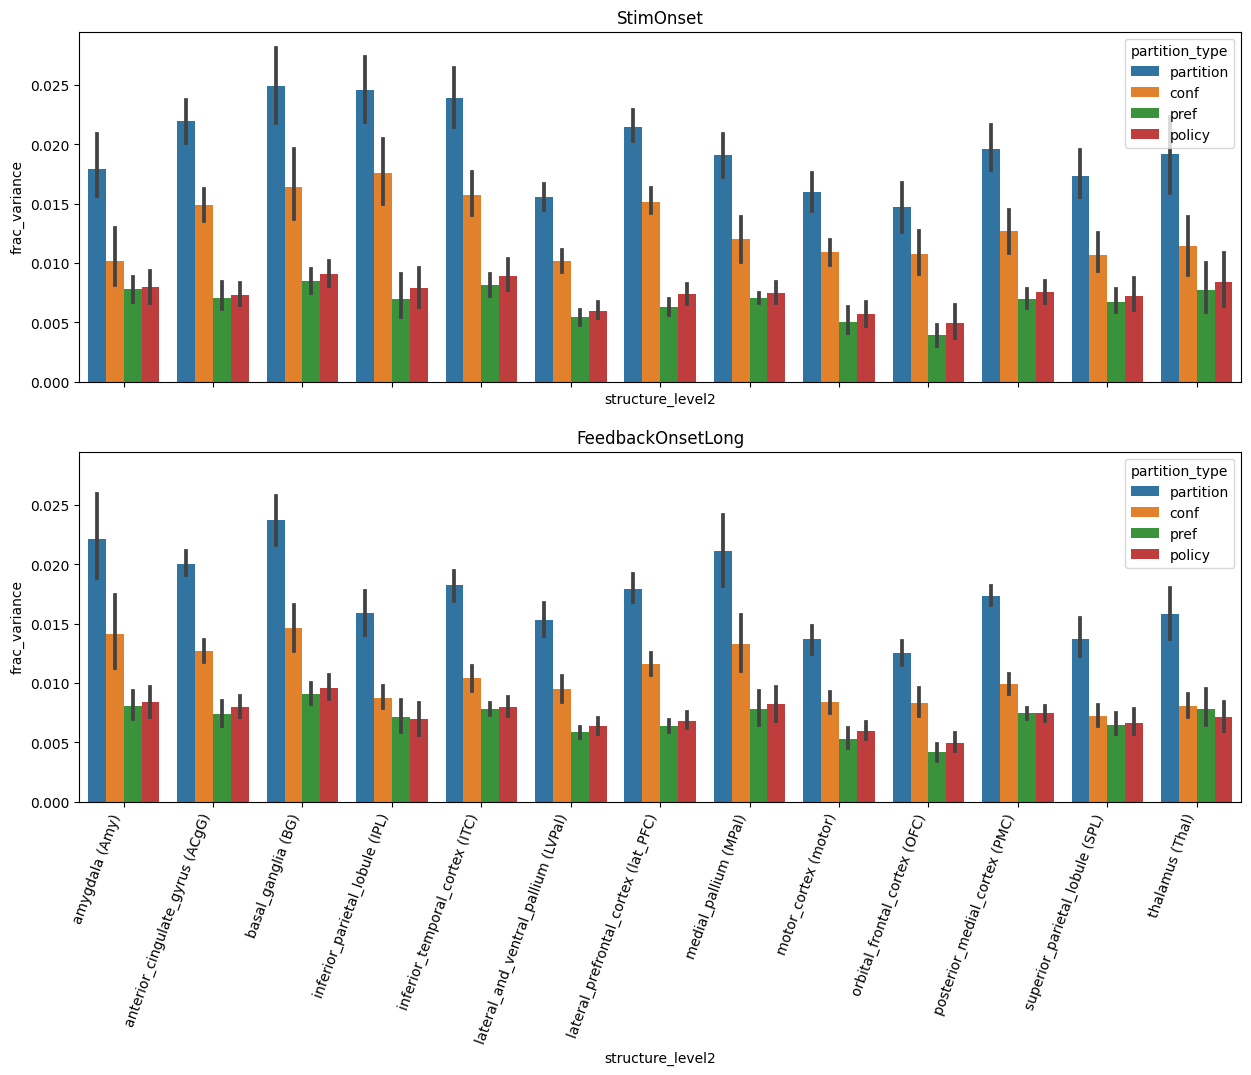

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True, sharey=True)

for i, event in enumerate(["StimOnset", "FeedbackOnsetLong"]):
    ax = axs[i]
    total_fracs = all_fracs[all_fracs.event == event]
    sns.barplot(total_fracs[total_fracs.structure_level2.isin(good_structures)], x="structure_level2", y="frac_variance", hue="partition_type", ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
    ax.set_title(event)


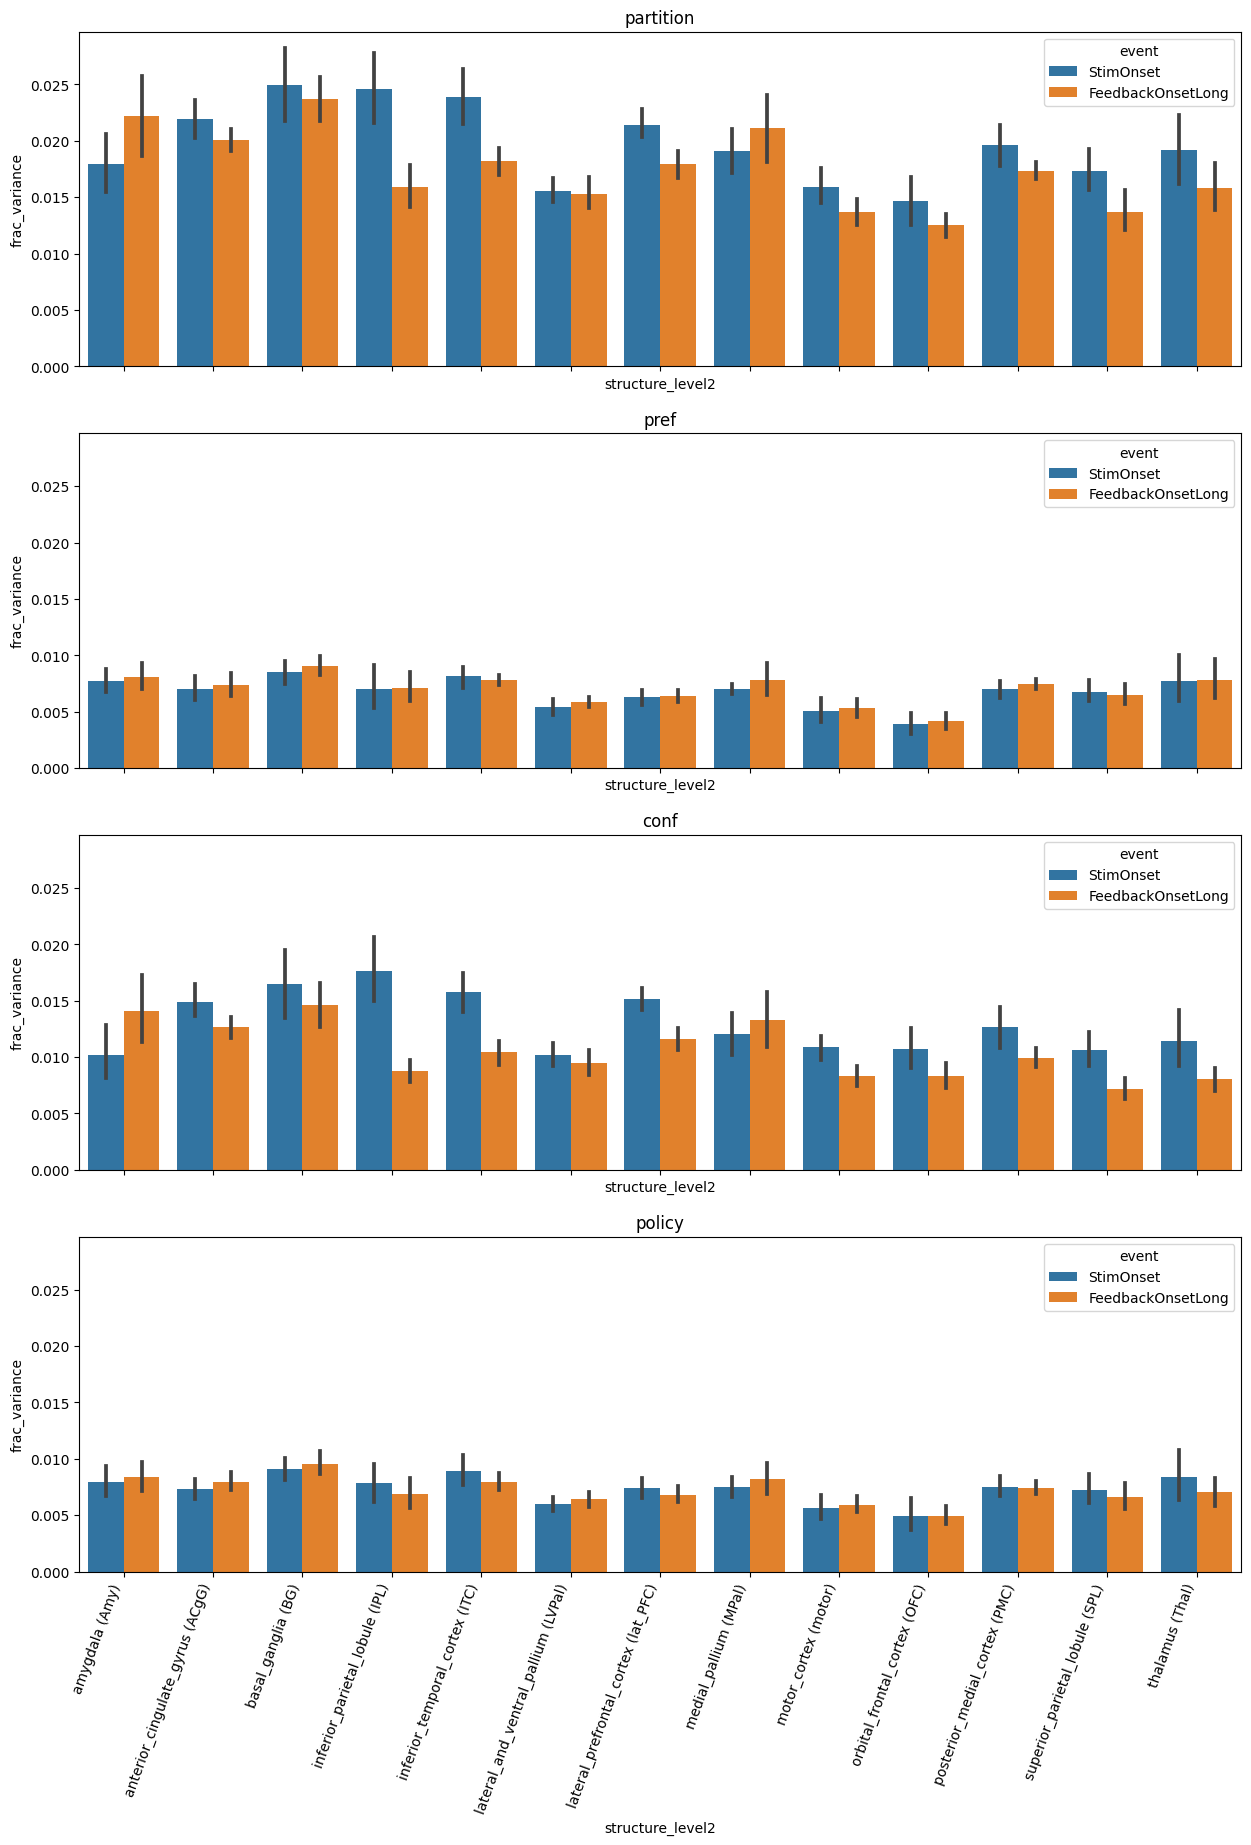

In [11]:
fig, axs = plt.subplots(4, 1, figsize=(15, 20), sharex=True, sharey=True)

for i, partition_type in enumerate(["partition", "pref", "conf", "policy"]):
    ax = axs[i]
    fracs = all_fracs[all_fracs.partition_type == partition_type]
    sns.barplot(fracs[fracs.structure_level2.isin(good_structures)], x="structure_level2", y="frac_variance", hue="event", ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
    ax.set_title(partition_type)


### What if we wanted to specify a subpopulation for both trial intervals?

In [2]:
sub = "BL"
FEATS_PATH = f"/data/patrick_res/sessions/{sub}/feats_at_least_3blocks.pickle"
feats = pd.read_pickle(FEATS_PATH)
unit_pos = pd.read_pickle(UNITS_PATH.format(sub=sub))
per_feat_totals = feats.groupby("feat").apply(lambda x: unit_pos[unit_pos.session.isin(x.sessions.iloc[0])].PseudoUnitID.nunique()).reset_index(name="num_units_recorded")

In [5]:
unit_pos[unit_pos.PseudoUnitID.isin([2019021509, 2019070908, 2019052913])][["Channel", "Unit", "session", "PseudoUnitID"]]

Channel Unit   session  PseudoUnitID
0       76    1  20190215    2019021509
1      116    2  20190709    2019070908
11      70    1  20190529    2019052913

In [5]:
sig_level = "95th"

args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.conditions = ["BeliefConf", "BeliefPartition"]
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.subject = sub

args.trial_event = "StimOnset"
stim_res = io_utils.read_anova_good_units(args, sig_level, "BeliefPartition", return_pos=False)
stim_res["trial_event"] = "StimOnset"

args.trial_event = "FeedbackOnsetLong"
fb_res = io_utils.read_anova_good_units(args, sig_level, "BeliefPartition", return_pos=False)
fb_res["trial_event"] = "FeedbackOnsetLong"

all_res = pd.concat((stim_res, fb_res))
all_res["session"] = (all_res.PseudoUnitID / 100).astype(int)

per_feat_sig = all_res.groupby("feat").PseudoUnitID.nunique().reset_index(name="num_units_sig")
per_feat_sess = all_res.groupby("feat").session.nunique().reset_index(name="num_sessions_sig")

per_feat_units = pd.merge(per_feat_sig, per_feat_totals, on="feat")
per_feat_units = pd.merge(per_feat_units, per_feat_sess, on="feat")
per_feat_units["ratio"] = per_feat_units.num_units_sig / per_feat_units.num_units_recorded

/data/patrick_res/anova/BL_StimOnset_BeliefConf_BeliefPartition_Response_Correct_Choice_Chose
/data/patrick_res/anova/BL_FeedbackOnsetLong_BeliefConf_BeliefPartition_Response_Correct_Choice_Chose


In [7]:
per_feat_units.style.hide(axis="index")

In [8]:
sig_units = all_res.groupby("feat").PseudoUnitID.unique().reset_index(name="PseudoUnitID").explode(column="PseudoUnitID")
sig_units.to_pickle(f"/data/patrick_res/firing_rates/{args.subject}/StimOnset_belief_partition_all_time_{sig_level}_units.pickle")
sig_units.to_pickle(f"/data/patrick_res/firing_rates/{args.subject}/FeedbackOnsetLong_belief_partition_all_time_{sig_level}_units.pickle")